## Step 1: Exploring the data

The dataset I'm using is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

In [8]:
import os
import glob

def read_imdb_data(data_dir='data/imdb-reviews'):
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
                
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
            
    # Return data, labels as nested dicts
    return data, labels

data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that the data is loaded, I'm just going to look at one of the positive reviews:

In [9]:
print(data['train']['pos'][2])

A solid, if unremarkable film. Matthau, as Einstein, was wonderful. My favorite part, and the only thing that would make me go out of my way to see this again, was the wonderful scene with the physicists playing badmitton, I loved the sweaters and the conversation while they waited for Robbins to retrieve the birdie.


And one with a negative sentiment

In [10]:
print(data['train']['neg'][2])

Ouch! This one was a bit painful to sit through. It has a cute and amusing premise, but it all goes to hell from there. Matthew Modine is almost always pedestrian and annoying, and he does not disappoint in this one. Deborah Kara Unger and John Neville turned in surprisingly decent performances. Alan Bates and Jennifer Tilly, among others, played it way over the top. I know that's the way the parts were written, and it's hard to blame actors, when the script and director have them do such schlock. If you're going to have outrageous characters, that's OK, but you gotta have good material to make it work. It didn't here. Run away screaming from this movie if at all possible.


Now I'll make a wordcloud visualization of the reviews

In [11]:
# Installing wordcloud
!pip install wordcloud

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
    100% |████████████████████████████████| 163kB 2.9MB/s ta 0:00:01


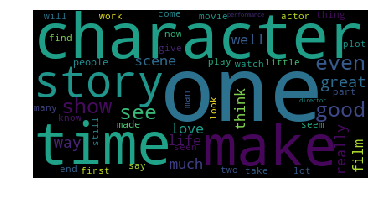

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'pos'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='black', max_words=50, stopwords = STOPWORDS.update(['br', 'film', 'movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

### Form training and test sets

Now I'm going to combine the positive and negative documents to get one unified training set and one unified test set.

In [29]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    
    # Combine positive and negative reviews and labels
    
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    # Shuffle reviews and corresponding labels
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    return data_train, data_test, labels_train, labels_test

data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Step 2. Preprocessing

The raw data still includes HTML. I'm going to remove these HTML tags, as well as remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and step the remaining words in each document

In [30]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup

# Regex for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords") # download a list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/devmachine/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
